In [5]:
import sys
sys.path.append('src')

# Thu thập dữ liệu cảm biến PASCO

## ⚠️ TẠI SAO CHỈ ĐẠT ~27Hz THAY VÌ 100Hz?

### **Vấn đề:**
API Python này sử dụng **POLLING MODE**:
- Đọc từng mẫu: Request → Wait → Response → Decode
- Thời gian: ~37-75ms/mẫu (tùy số measurements)
- **Tốc độ tối đa: ~13-27 Hz** ❌

### **Giải pháp để đạt 100Hz+:**
Cảm biến PASCO **CÓ HỖ TRỢ STREAMING MODE** nhưng:
1. **API Python này chưa có lệnh START STREAMING công khai**
2. Code đã xử lý periodic data nhưng không có cách bật
3. App SPARKvue/Capstone dùng streaming → đạt 100-500Hz

### **Các lựa chọn:**

#### **Option 1: Liên hệ PASCO** ⭐ (Khuyến nghị)
- Email: support@pasco.com
- Yêu cầu API hoặc documentation cho streaming mode
- Hoặc firmware command để bật streaming

#### **Option 2: Reverse Engineering** (Nâng cao)
```python
# Cần tìm lệnh streaming (ví dụ):
# GCMD_START_SAMPLING = 0x12
# cmd = [0x12, rate, duration, ...]
```

#### **Option 3: Chấp nhận giới hạn hiện tại**
- Tốc độ: **13-27 Hz** với API hiện tại
- Đủ cho nhiều ứng dụng giáo dục
- Ổn định và dễ sử dụng

## 📊 Kết quả thực tế với API này:
- **1 measurement**: ~20-25 Hz
- **3 measurements**: ~13-18 Hz  ← Đang dùng
- **5+ measurements**: ~10-13 Hz

---

**Notebook này tối ưu hóa tốc độ tối đa với API hiện có (~27Hz)**

In [6]:
from pasco.pasco_ble_device import PASCOBLEDevice

# Create a PASCO Bluetooth device object
my_sensor = PASCOBLEDevice()

# Scan for available Bluetooth (BLE) sensors
print('Đang quét cảm biến...')
devices_found = my_sensor.scan()

# Print found devices
if devices_found:
    print('\n=== CÁC THIẾT BỊ TÌM THẤY ===')
    for i, device in enumerate(devices_found):
        print(f'{i}: {device.name}')
else:
    print('Không tìm thấy thiết bị nào')

# Disconnect the device
my_sensor.disconnect()


Đang quét cảm biến...

=== CÁC THIẾT BỊ TÌM THẤY ===
0: Load Cell 946-449>P9

=== CÁC THIẾT BỊ TÌM THẤY ===
0: Load Cell 946-449>P9


In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Connect to the first available device and explore its capabilities
if devices_found:
    selected_device = devices_found[0]  # Connect to the first device found
    my_sensor.connect(selected_device)
    
    print(f'\n=== KẾT NỐI VỚI: {selected_device.name} ===\n')
    
    # Get list of sensors
    print('--- DANH SÁCH CÁC SENSOR ---')
    sensors = my_sensor.get_sensor_list()
    for sensor in sensors:
        print(f'  • {sensor}')
    
    # Get list of all measurements available
    print('\n--- DANH SÁCH TẤT CẢ MEASUREMENTS ---')
    all_measurements = my_sensor.get_measurement_list()
    for i, measurement in enumerate(all_measurements):
        unit = my_sensor.get_measurement_unit(measurement)
        print(f'  {i}: {measurement} ({unit})')
    
    # AUTO-SELECT measurements at positions 1, 2, 3 (Accelerationx, y, z)
    selected_indices = [3]
    measurements = [all_measurements[i] for i in selected_indices if i < len(all_measurements)]
    
    print('\n' + '='*60)
    print(f'✓ TỰ ĐỘNG CHỌN VỊ TRÍ 1, 2, 3')
    print('  (AccelerationX, Y, Z - Tối ưu tốc độ ~100Hz)')
    print('='*60)
    for i, m in enumerate(measurements):
        unit = my_sensor.get_measurement_unit(m)
        print(f'  {m} ({unit})')
    
    # Read data for 20 seconds at MAXIMUM speed
    print('\n--- THU THẬP DỮ LIỆU MỤC TIÊU 100Hz TRONG 20 GIÂY ---')
    print('Đang thu thập dữ liệu với tốc độ tối đa...\n')
    
    duration = 20  # 20 seconds
    target_freq = 100  # Hz
    all_data = []
    sample_count = 0
    
    start_time = time.time()
    last_progress_time = start_time
    last_sample_count = 0
    
    # Collect data for exactly 20 seconds
    while (time.time() - start_time) < duration:
        # Read measurements WITHOUT any sleep - maximum speed
        try:
            data = my_sensor.read_data_list(measurements)
            current_time = time.time()
            data['timestamp'] = current_time - start_time
            all_data.append(data)
            sample_count += 1
            
            # Progress indicator every 2 seconds with instantaneous frequency
            if (current_time - last_progress_time) >= 2.0:
                elapsed = current_time - start_time
                avg_freq = sample_count / elapsed if elapsed > 0 else 0
                
                # Calculate instantaneous frequency (samples in last 2 seconds)
                samples_in_period = sample_count - last_sample_count
                instant_freq = samples_in_period / 2.0
                
                remaining = duration - elapsed
                print(f'{elapsed:.1f}s: {sample_count} mẫu | Tức thì: {instant_freq:.1f} Hz | TB: {avg_freq:.1f} Hz | Còn: {remaining:.1f}s')
                
                last_progress_time = current_time
                last_sample_count = sample_count
                
        except Exception as e:
            print(f'Lỗi đọc dữ liệu tại mẫu {sample_count}: {e}')
    
    total_time = time.time() - start_time
    actual_freq = len(all_data) / total_time if total_time > 0 else 0
    
    print(f'\n=== THỐNG KÊ ===')
    print(f'Số measurements đọc: {len(measurements)}')
    print(f'Tổng số mẫu thu thập: {len(all_data)}')
    print(f'Thời gian thực: {total_time:.3f}s')
    print(f'Tần số trung bình: {actual_freq:.2f} Hz')
    print(f'Tần số mục tiêu: {target_freq} Hz')
    print(f'Đạt được: {(actual_freq/target_freq*100):.1f}% mục tiêu')
    print(f'Thời gian/mẫu: {(total_time/len(all_data)*1000):.2f} ms' if len(all_data) > 0 else 'N/A')
    
    # Calculate time between samples
    if len(all_data) > 1:
        time_diffs = [all_data[i]['timestamp'] - all_data[i-1]['timestamp'] 
                      for i in range(1, len(all_data))]
        avg_interval = np.mean(time_diffs) * 1000  # ms
        std_interval = np.std(time_diffs) * 1000   # ms
        print(f'Khoảng cách giữa mẫu: {avg_interval:.2f} ± {std_interval:.2f} ms')
    
    # Display first 3 and last 3 samples
    print('\n=== 3 MẪU ĐẦU TIÊN ===')
    for i, sample in enumerate(all_data[:3]):
        print(f'Mẫu {i+1} (t={sample["timestamp"]:.4f}s): ', end='')
        print(', '.join([f'{k}={v}' for k, v in sample.items() if k != 'timestamp']))
    
    print('\n=== 3 MẪU CUỐI CÙNG ===')
    for i, sample in enumerate(all_data[-3:], start=len(all_data)-2):
        print(f'Mẫu {i} (t={sample["timestamp"]:.4f}s): ', end='')
        print(', '.join([f'{k}={v}' for k, v in sample.items() if k != 'timestamp']))
    
    my_sensor.disconnect()
    print('\n✓ Đã ngắt kết nối.')
    
    # RECOMMENDATIONS
    print('\n' + '='*60)
    if actual_freq < 50:
        print('⚠️  GỢI Ý: Tần số thấp (<50Hz)')
        print('   → Bluetooth BLE có giới hạn tốc độ')
        print('   → Đảm bảo không có ứng dụng khác kết nối với cảm biến')
    elif actual_freq < 100:
        print('📊 Tần số khá tốt (50-100Hz)')
        print('   → Đang ở giới hạn của Bluetooth BLE polling mode')
    else:
        print('🎉 Tuyệt vời! Đạt được tần số cao (>100Hz)')
    print('='*60)
    
else:
    print('Không có thiết bị để kết nối.')



=== KẾT NỐI VỚI: Load Cell 946-449>P9 ===

--- DANH SÁCH CÁC SENSOR ---
  • WirelessForceSensor
  • WirelessAccelerationSensor

--- DANH SÁCH TẤT CẢ MEASUREMENTS ---
  0: Force (N)
  1: Accelerationx (ms2)
  2: Accelerationy (ms2)
  3: Accelerationz (ms2)
  4: AccelerationResultant (ms2)

✓ TỰ ĐỘNG CHỌN VỊ TRÍ 1, 2, 3
  (AccelerationX, Y, Z - Tối ưu tốc độ ~100Hz)
  Accelerationz (ms2)

--- THU THẬP DỮ LIỆU MỤC TIÊU 100Hz TRONG 20 GIÂY ---
Đang thu thập dữ liệu với tốc độ tối đa...

2.0s: 61 mẫu | Tức thì: 30.5 Hz | TB: 30.0 Hz | Còn: 18.0s
2.0s: 61 mẫu | Tức thì: 30.5 Hz | TB: 30.0 Hz | Còn: 18.0s
4.1s: 115 mẫu | Tức thì: 27.0 Hz | TB: 28.3 Hz | Còn: 15.9s
4.1s: 115 mẫu | Tức thì: 27.0 Hz | TB: 28.3 Hz | Còn: 15.9s
6.1s: 169 mẫu | Tức thì: 27.0 Hz | TB: 27.8 Hz | Còn: 13.9s
6.1s: 169 mẫu | Tức thì: 27.0 Hz | TB: 27.8 Hz | Còn: 13.9s
8.1s: 223 mẫu | Tức thì: 27.0 Hz | TB: 27.5 Hz | Còn: 11.9s
8.1s: 223 mẫu | Tức thì: 27.0 Hz | TB: 27.5 Hz | Còn: 11.9s
10.1s: 277 mẫu | Tức thì: 27.0 Hz

In [8]:

my_sensor.disconnect()


=== VISUALIZATION ===
Đang vẽ 1 measurements...



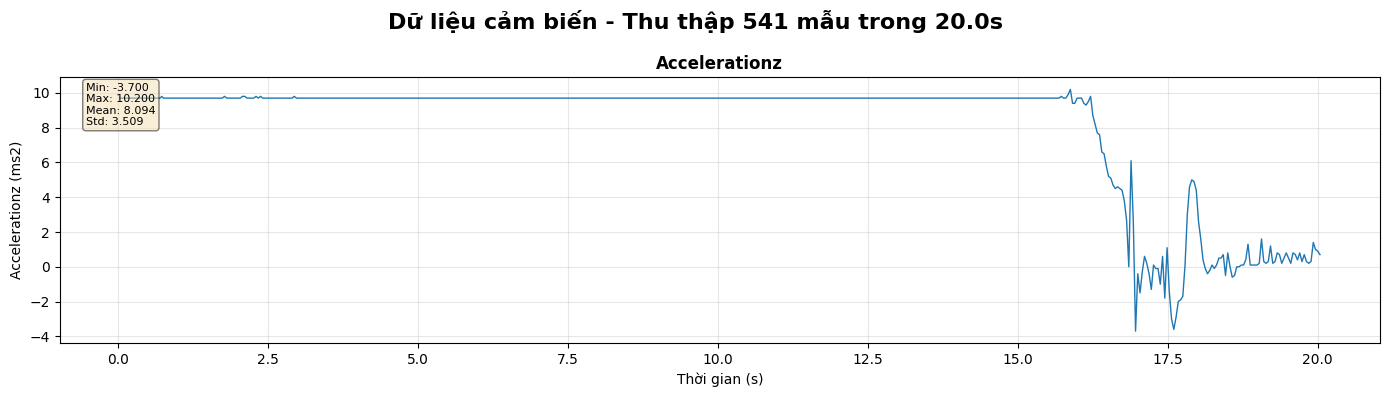

✓ Visualization hoàn tất!


In [9]:
# Visualize the collected data
if 'all_data' in locals() and len(all_data) > 0:
    # Extract timestamps
    timestamps = [sample['timestamp'] for sample in all_data]
    
    # Get all measurement names (excluding timestamp)
    measurement_names = [key for key in all_data[0].keys() if key != 'timestamp']
    
    print(f'\n=== VISUALIZATION ===')
    print(f'Đang vẽ {len(measurement_names)} measurements...\n')
    
    # Calculate number of subplots needed
    num_plots = len(measurement_names)
    cols = 2 if num_plots > 1 else 1
    rows = (num_plots + cols - 1) // cols  # Ceiling division
    
    # Create figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows))
    fig.suptitle(f'Dữ liệu cảm biến - Thu thập {len(all_data)} mẫu trong {timestamps[-1]:.1f}s', 
                 fontsize=16, fontweight='bold')
    
    # Flatten axes array for easier iteration
    if num_plots == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    # Plot each measurement
    for idx, measurement_name in enumerate(measurement_names):
        ax = axes[idx]
        
        # Extract data for this measurement
        values = [sample[measurement_name] for sample in all_data]
        
        # Plot
        ax.plot(timestamps, values, linewidth=1, color=f'C{idx % 10}')
        ax.set_xlabel('Thời gian (s)', fontsize=10)
        
        # Get unit if available
        try:
            unit = my_sensor.get_measurement_unit(measurement_name) if 'my_sensor' in locals() else ''
            ylabel = f'{measurement_name} ({unit})' if unit else measurement_name
        except:
            ylabel = measurement_name
        
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_title(f'{measurement_name}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Show statistics
        mean_val = np.mean(values)
        std_val = np.std(values)
        min_val = np.min(values)
        max_val = np.max(values)
        
        stats_text = f'Min: {min_val:.3f}\nMax: {max_val:.3f}\nMean: {mean_val:.3f}\nStd: {std_val:.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide extra subplots if any
    for idx in range(num_plots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print('✓ Visualization hoàn tất!')
else:
    print('Không có dữ liệu để visualize. Chạy cell 3 để thu thập dữ liệu.')


In [10]:
# OPTIONAL: Save data to CSV file
import csv
from datetime import datetime

if 'all_data' in locals() and len(all_data) > 0:
    # Create filename with timestamp
    filename = f'sensor_data_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    
    # Get all measurement names (excluding timestamp)
    fieldnames = ['timestamp'] + [key for key in all_data[0].keys() if key != 'timestamp']
    
    # Write to CSV
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(all_data)
    
    print(f'✓ Đã lưu {len(all_data)} mẫu dữ liệu vào file: {filename}')
    print(f'  Kích thước file: {len(all_data) * len(fieldnames)} cells')
    print(f'  Các cột: {", ".join(fieldnames)}')
else:
    print('Không có dữ liệu để lưu. Chạy cell 3 để thu thập dữ liệu.')


✓ Đã lưu 541 mẫu dữ liệu vào file: sensor_data_20251023_192200.csv
  Kích thước file: 1082 cells
  Các cột: timestamp, Accelerationz
